In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
yaba_properties = pd.read_json("./data/yaba-properties.json")
surulere_properties = pd.read_json("./data/surulere-properties.json")
maryland_properties = pd.read_json("./data/maryland-properties.json")
gbagada_properties = pd.read_json("./data/gbagada-properties.json")

data = pd.concat([yaba_properties, surulere_properties, maryland_properties, gbagada_properties])

## Data cleaning

In [3]:
# Get number of rooms
def roomCount(type):
    if (len(re.findall('\d+', type)) > 0):
        return re.findall('\d+', type)[0]
    elif (re.search(r'(self|flat)', type, flags=re.IGNORECASE)):
        return "1"

data['number of rooms'] = data.type.map(roomCount).astype('int64')

In [4]:
# Get city and town
def cityAndTown(location):
    arr = location.split(', ')
    arr.pop()
    arr.reverse()
    
    city = arr[0].strip()
    town = arr[1].strip() if len(arr) > 1 else np.nan
    
    return city, town

data['city'] = data.location.map(lambda loc: cityAndTown(loc)[0])
data['town'] = data.location.map(lambda loc: cityAndTown(loc)[1])

In [5]:
# convert rent to int
data['rent'] = data['rent'].map(lambda r: r.replace(',','')).astype('int64')

In [6]:
data['id'] = range(0, len(data))
data = data.set_index("id")

In [7]:
from datetime import datetime, timedelta

# extract month added
def extractDate(item):
    date = item.replace('Added ', '').replace('on ', '').lower()
    if date == "yesterday":
        return (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
    else:
        return date

data['addedOn'] = data.addedOn.map(lambda x: pd.to_datetime(extractDate(x)))
data['monthAdded'] = data.addedOn.map(lambda x: x.month_name())

In [8]:
# extract serviced or furnished
data['serviced'] = data.shortDesc.map(lambda desc: int(bool(re.search(r'serviced', desc, flags=re.IGNORECASE))))
data['furnished'] = data.shortDesc.map(lambda desc: int(bool(re.search(r'furnished', desc, flags=re.IGNORECASE))))

In [9]:
# extract number of bathrooms and number of toilets
data.metaProps.head()

def extractKey(prop, key):
    if prop.get(key):
        return prop.get(key)
    elif prop.get(key + "s"):
        return prop.get(key + "s")
    else:
        return 0

data["number of bathrooms"] = data.metaProps.map(lambda prop: extractKey(prop, "Bathroom"))
data["number of toilets"] = data.metaProps.map(lambda prop: extractKey(prop, "Toilet"))

In [10]:
# extract house agent
def extractAgent(x): 
    agent = x.replace('\n', '').replace('\xa0', '').strip(' ')
    if len(agent) == 0:
        return np.nan
    else:
        return agent

data["marketedBy"] = data.marketedBy.map(extractAgent)

In [11]:
# remove all investment based houses
data.at[412, 'rent'] = 325000

data[data['shortDesc'] == "Sunplanet Smart Landlord Investment"]
data.drop(index=192, inplace=True)

data[data['link'] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/mini-flats/lagos/yaba/onike/549971-newly-built-2bedroom-at-onike"]
data.drop(index=322, inplace=True)

data[data['link'] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/lagos/surulere/779480-luxury-and-executive-3-bedrooms-with-3-tiolets-with-wardrobes"]
data.at[416, 'rent'] = 1000000

data[data['link'] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/self-contained/lagos/gbagada/782003-a-executive-brand-newly-built-ensuite-2-bedrooms-flat"]
data.at[713, 'number of rooms'] = "2"

data[data["link"] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/lagos/gbagada/gbagada-phase-1/706117-newly-built-2-bedroom"]
data.at[781, 'number of rooms'] = "2"

data[data["link"] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/self-contained/lagos/yaba/onike/798173-newly-built-roomself-for-15-years-lease"]
data.drop(index=9, inplace=True)

data[data['rent'] == 40000000]
data.drop(index=814, inplace=True)

In [12]:
data['number of bathrooms'] = pd.to_numeric(data['number of bathrooms'])
data['number of toilets'] = pd.to_numeric(data['number of toilets'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 0 to 813
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   type                 811 non-null    object        
 1   shortDesc            811 non-null    object        
 2   link                 811 non-null    object        
 3   rent                 811 non-null    int64         
 4   addedOn              811 non-null    datetime64[ns]
 5   location             811 non-null    object        
 6   marketedBy           767 non-null    object        
 7   metaProps            811 non-null    object        
 8   number of rooms      811 non-null    int64         
 9   city                 811 non-null    object        
 10  town                 676 non-null    object        
 11  monthAdded           811 non-null    object        
 12  serviced             811 non-null    int64         
 13  furnished            811 non-null  

In [162]:
df_o = data[['rent', 'number of rooms', 'city', 'serviced', 'furnished', 
           'number of bathrooms', 'number of toilets', 'monthAdded']]

In [163]:
df = pd.get_dummies(df_o, columns=['monthAdded'], prefix='monthAdded')

(array([342.,   0.,   0., 244.,   0.,   0.,  62.,   0.,   0., 163.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

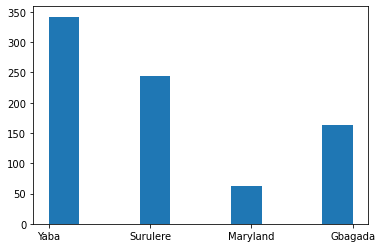

In [164]:
plt.hist(df['city'])

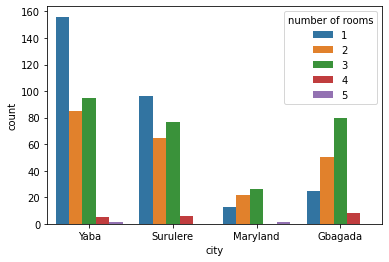

In [165]:
sns.countplot(x='city', hue='number of rooms', data=df_o)

This tells us that in mostly single to unit families live in Yaba and Surulere. While in Maryland and Gbagada it's mostly family houses.

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 0 to 813
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   rent                  811 non-null    int64 
 1   number of rooms       811 non-null    int64 
 2   city                  811 non-null    object
 3   serviced              811 non-null    int64 
 4   furnished             811 non-null    int64 
 5   number of bathrooms   811 non-null    int64 
 6   number of toilets     811 non-null    int64 
 7   monthAdded_April      811 non-null    uint8 
 8   monthAdded_August     811 non-null    uint8 
 9   monthAdded_December   811 non-null    uint8 
 10  monthAdded_February   811 non-null    uint8 
 11  monthAdded_January    811 non-null    uint8 
 12  monthAdded_July       811 non-null    uint8 
 13  monthAdded_June       811 non-null    uint8 
 14  monthAdded_March      811 non-null    uint8 
 15  monthAdded_May        811 non-null    ui

## Apply model

In [167]:
X = df.drop(columns=['city'])
y = df.city

In [168]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [178]:
from sklearn import metrics

def applyModel(model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # print metrics evaluation
    print(metrics.classification_report(y_test, predictions))
    print(metrics.confusion_matrix(y_test, predictions))
    
    return predictions

### Knn

In [170]:
from sklearn.neighbors import KNeighborsClassifier

In [171]:
knn = KNeighborsClassifier()
knn_preds = applyModel(knn)

0.4024840628988051
              precision    recall  f1-score   support

     Gbagada       0.32      0.42      0.37        57
    Maryland       0.24      0.22      0.23        18
    Surulere       0.30      0.36      0.33        69
        Yaba       0.56      0.43      0.48       124

    accuracy                           0.40       268
   macro avg       0.36      0.36      0.35       268
weighted avg       0.42      0.40      0.40       268

[[24  2 14 17]
 [ 8  4  2  4]
 [17  6 25 21]
 [25  5 41 53]]


In [172]:
y_test.value_counts()

Yaba        124
Surulere     69
Gbagada      57
Maryland     18
Name: city, dtype: int64

### Random forests

In [173]:
from sklearn.ensemble import RandomForestClassifier

In [181]:
rf = RandomForestClassifier()
rf_preds = applyModel(rf)

              precision    recall  f1-score   support

     Gbagada       0.41      0.37      0.39        57
    Maryland       0.27      0.22      0.24        18
    Surulere       0.36      0.49      0.41        69
        Yaba       0.64      0.55      0.59       124

    accuracy                           0.47       268
   macro avg       0.42      0.41      0.41       268
weighted avg       0.49      0.47      0.48       268

[[21  2 21 13]
 [ 5  4  4  5]
 [10  4 34 21]
 [15  5 36 68]]
